<a href="https://colab.research.google.com/github/BoKna031/Image_inpainting/blob/merging_new_data/Image_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Kaggle dataset

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d amanara/photos

Dataset URL: https://www.kaggle.com/datasets/amanara/photos
License(s): unknown
 99% 271M/274M [00:06<00:00, 57.1MB/s]
100% 274M/274M [00:06<00:00, 47.7MB/s]


In [ ]:
!unzip photos.zip "Dataset/Training_Data/Cat/*" ;

In [4]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 98% 769M/788M [00:06<00:00, 183MB/s]
100% 788M/788M [00:06<00:00, 127MB/s]


In [ ]:
!unzip microsoft-catsvsdogs-dataset.zip "PetImages/Cat/*";

# Data preparation

In [6]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

TRAIN = 'Train'
TEST = 'Test'
img_size = (64, 64)

def adjust_box_coordinate(csv_df):
  ORG_IMG_SIZE = (256,256)
  scale_xy = img_size[0] / ORG_IMG_SIZE[0]
  csv_df[['box1_row', 'box1_col', 'box2_row', 'box2_col']] = (csv_df[['box1_row', 'box1_col', 'box2_row', 'box2_col']] * scale_xy).astype(int)


def load_images_from_folder(folder, suported_formats):
    images = []
    for filename in os.listdir(folder):
      _, ext = os.path.splitext(filename)
      if ext.lower() in supported_formats:
          img = cv2.imread(os.path.join(folder, filename))
          if img is not None:
            img = cv2.resize(img, img_size)
            id, format = _parse_filename(filename)
            images.append({'filename': filename, 'id': id,'format': format, 'image': img})
    images_df = pd.DataFrame(images, columns=['filename', 'id', 'format', 'image'])
    return images_df

import re

def _parse_filename(filename):
    regex_pattern =  r'\D*(\d+)\)?\.(\w+)$'

    match = re.match(regex_pattern, filename)

    if match:
        id = int(match.group(1))
        format =  match.group(2)
        return id, format
    else:
        return  None, None

def load_csv(path):
    csv = pd.read_csv(path)
    adjust_box_coordinate(csv)
    csv['id'] = csv['filename'].apply(lambda x: _parse_filename(x)[0])
    return csv

def show_img(img, gray = False):
  if gray:
    plt.imshow(img, 'gray')
  else:
    plt.imshow(img)
  plt.axis('off')
  plt.show()


# Data analyzing

In [7]:
def find_distinct_file_formats(directory):
    file_formats = set()

    for root, dirs, files in os.walk(directory):
        for file in files:
            _, ext = os.path.splitext(file)
            if ext:
                file_formats.add(ext)

    return file_formats

In [8]:
cat1_dir_path = os.path.join('Dataset', 'Training_Data', 'Cat', 'Unmasked_Train')
cat2_dir_path = os.path.join('PetImages', 'Cat')

In [9]:
print(find_distinct_file_formats(cat1_dir_path))
print(find_distinct_file_formats(cat2_dir_path))

{'.png', '.jpeg', '.jpg'}
{'.db', '.jpg'}


In [10]:
supported_formats = ['.png', '.jpg', '.jpeg']

In [11]:
x1_img = load_images_from_folder(cat1_dir_path, supported_formats)
x2_img = load_images_from_folder(cat2_dir_path, supported_formats);
img_df = pd.concat([x1_img, x2_img], ignore_index=True)

In [15]:
x2_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12476 entries, 0 to 12475
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  12476 non-null  object
 1   id        12476 non-null  int64 
 2   format    12476 non-null  object
 3   image     12476 non-null  object
dtypes: int64(1), object(3)
memory usage: 390.0+ KB


In [18]:
csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1750 non-null   int64 
 1   filename    1750 non-null   object
 2   box1_row    1750 non-null   int64 
 3   box1_col    1750 non-null   int64 
 4   box2_row    1750 non-null   int64 
 5   box2_col    1750 non-null   int64 
 6   id          1750 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 95.8+ KB


In [21]:
x2_img.head(5)

,filename,id,format,image
0,3636.jpg,3636,jpg,"[[[96, 90, 109], [81, 76, 91], [87, 82, 89], [..."
1,3121.jpg,3121,jpg,"[[[31, 28, 40], [30, 33, 44], [30, 38, 51], [3..."
2,7863.jpg,7863,jpg,"[[[110, 37, 170], [109, 36, 170], [108, 36, 16..."
3,8225.jpg,8225,jpg,"[[[212, 231, 238], [214, 233, 240], [215, 234,..."
4,6357.jpg,6357,jpg,"[[[195, 199, 200], [198, 201, 203], [196, 200,..."


In [14]:
x1_img.shape

(1750, 4)

In [25]:
current_size = x1_img.shape[0]
csv =  load_csv(os.path.join('Dataset', 'Training_Data', 'Cat', 'masked_info.csv'))
i = 0
for ind in x2_img.index:
    csv_row_copy = csv.iloc[i].copy()
    csv_row_copy['filename'] = x2_img['filename'][ind]
    csv_row_copy['id'] = x2_img['id'][ind]
    csv = csv._append(csv_row_copy, ignore_index=True)
    i = (i + 1) % current_size

In [29]:
csv[csv['filename'] == '5625.jpg'].iloc[0]

Unnamed: 0         438
filename      5625.jpg
box1_row            35
box1_col             9
box2_row             6
box2_col            45
id                5625
Name: 10938, dtype: object

In [ ]:
img_df[img_df['filename'] == '5625.jpg'].iloc[0]

filename                                             5625.jpg
id                                                       5625
format                                                    jpg
image       [[[1, 1, 1], [1, 1, 1], [12, 13, 9], [9, 10, 6...
Name: 1750, dtype: object

In [ ]:
x1_img.iloc[0]

filename                                   Cat-Train (18).jpg
id                                                         18
format                                                    jpg
image       [[[133, 114, 3], [134, 116, 3], [135, 117, 2],...
Name: 0, dtype: object

In [ ]:
x2_img.iloc[0]

filename                                             5625.jpg
id                                                       5625
format                                                    jpg
image       [[[1, 1, 1], [1, 1, 1], [12, 13, 9], [9, 10, 6...
Name: 0, dtype: object

In [30]:
print('total number of invalid ids ', img_df['id'].isnull().sum())

total number of invalid ids  0


In [31]:
box_size = [15, 15]

def is_within_bounds(row, col):
  return row + box_size[0] <= img_size[0] and col + box_size[1] <= img_size[1]

In [32]:
csv['box1_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box1_row'], row['box1_col']), axis=1)
csv['box2_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box2_row'], row['box2_col']), axis=1)
invalid_boxes = csv[(~csv['box1_within_bounds']) | (~csv['box2_within_bounds'])]

In [ ]:
csv.head()

In [33]:
print(f"There is {invalid_boxes.shape[0]} images that have invalid boxes")

There is 0 images that have invalid boxes


In [34]:
x_cp = img_df.copy(deep=True)

In [36]:
import numpy as np
def draw_masks(image, csv_row , box_size):
    col1, row1, col2, row2 = csv_row['box1_row'], csv_row['box1_col'], csv_row['box2_row'], csv_row['box2_col']
    mask = np.zeros(img_size)
    mask[row1:row1+box_size[0], col1:col1+box_size[1]] = 1
    #mask[row2:row2+box_size[0], col2:col2+box_size[1]] = 1
    img_cp = image.copy()
    img_cp[mask==1] = 0
    mask = mask[:, :, np.newaxis]
    rgbm_image = np.concatenate((img_cp, mask), axis=2).astype(np.int32)
    return rgbm_image

In [37]:
x_cp['image'] = x_cp.apply(lambda row: draw_masks(row['image'], csv[csv['filename'] == row['filename']].iloc[0], box_size), axis = 1)

In [38]:
type(x_cp.iloc[0]['image'])

numpy.ndarray

In [40]:
merged_data = pd.merge(x_cp, csv, on='filename')
merged_data = pd.merge(merged_data, img_df, on = 'filename')

In [41]:
final_table_columns = ['filename', 'image_x', 'image_y', 'box2_row', 'box2_col']
train_df = merged_data.drop(columns=[col for col in merged_data if col not in final_table_columns])

In [ ]:
#train_df.head()

In [42]:
test_row = train_df.iloc[3]
x_coord, y_coord = test_row['box2_row'], test_row['box2_col']
print(x_coord, y_coord)

37 5


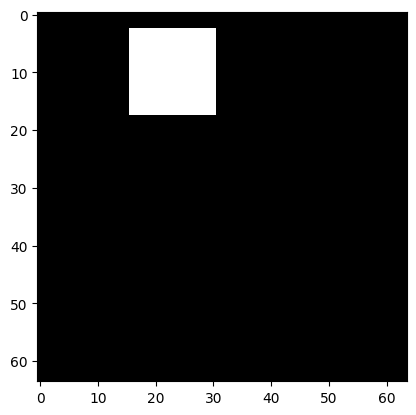

In [43]:
plt.imshow(test_row['image_x'][:,:,3], cmap='gray')
plt.show()

In [44]:
def crop_box(rgbm, y_img):
  mask = rgbm[:,:,3]
  rows, cols = np.where(mask == 1)

  min_row, max_row = np.min(rows), np.max(rows)
  min_col, max_col = np.min(cols), np.max(cols)

  return y_img[min_row:max_row + 1, min_col:max_col + 1, :]


In [45]:
train_df['image_y'] = train_df.apply(lambda row: crop_box(row['image_x'], row['image_y']), axis = 1)

In [46]:
train_df.iloc[1]['image_y']

array([[[250, 255, 250],
        [225, 240, 251],
        [160, 163, 192],
        [215, 203, 224],
        [238, 228, 224],
        [248, 233, 228],
        [226, 236, 251],
        [133, 164, 206],
        [ 28,  72, 121],
        [ 30,  62, 108],
        [133, 190, 250],
        [103, 180, 245],
        [174, 236, 255],
        [182, 216, 228],
        [ 37,  56,  78]],

       [[248, 250, 255],
        [193, 204, 234],
        [152, 149, 187],
        [229, 220, 230],
        [238, 229, 223],
        [243, 235, 240],
        [177, 203, 237],
        [ 66, 120, 156],
        [ 56,  63, 100],
        [ 38,  77, 100],
        [113, 179, 233],
        [ 95, 185, 241],
        [158, 222, 250],
        [192, 229, 233],
        [106, 125, 131]],

       [[225, 230, 247],
        [168, 179, 231],
        [121, 116, 166],
        [231, 226, 228],
        [238, 234, 227],
        [226, 231, 246],
        [ 70, 120, 171],
        [ 79, 147, 215],
        [ 73,  95, 157],
        [118, 161, 196],
        [138, 190, 243],
        [ 80, 138, 208],
        [101, 149, 210],
        [174, 233, 246],
        [164, 230, 241]],

       [[184, 197, 221],
        [140, 155, 222],
        [134, 132, 190],
        [235, 230, 235],
        [237, 234, 230],
        [202, 215, 237],
        [ 34,  99, 160],
        [ 21,  97, 185],
        [ 27, 119, 198],
        [147, 200, 241],
        [191, 228, 252],
        [136, 173, 234],
        [134, 159, 232],
        [196, 237, 254],
        [173, 223, 243]],

       [[169, 199, 216],
        [128, 143, 209],
        [159, 160, 213],
        [236, 233, 233],
        [225, 233, 237],
        [146, 182, 227],
        [ 54, 132, 197],
        [ 39, 120, 207],
        [ 75, 164, 235],
        [174, 224, 246],
        [203, 226, 246],
        [156, 183, 238],
        [110, 132, 219],
        [174, 211, 239],
        [205, 236, 237]],

       [[199, 211, 249],
        [133, 142, 201],
        [213, 213, 245],
        [240, 236, 234],
        [229, 238, 251],
        [ 84, 120, 184],
        [ 69, 143, 228],
        [ 68, 154, 232],
        [132, 193, 240],
        [188, 216, 240],
        [177, 199, 239],
        [116, 133, 202],
        [109, 125, 214],
        [156, 183, 230],
        [203, 226, 252]],

       [[ 96, 102, 171],
        [151, 157, 219],
        [232, 229, 248],
        [238, 233, 233],
        [206, 215, 240],
        [ 62,  98, 177],
        [ 42, 113, 208],
        [ 54, 143, 210],
        [162, 202, 234],
        [194, 211, 240],
        [174, 193, 232],
        [169, 190, 231],
        [183, 205, 252],
        [175, 201, 234],
        [177, 204, 222]],

       [[ 26,  19, 170],
        [ 43,  49, 130],
        [231, 234, 232],
        [241, 236, 237],
        [183, 193, 224],
        [ 28,  68, 147],
        [ 51, 122, 212],
        [ 82, 165, 230],
        [167, 202, 237],
        [168, 194, 228],
        [174, 198, 210],
        [187, 211, 231],
        [192, 219, 233],
        [194, 219, 243],
        [205, 234, 249]],

       [[ 10,  13, 185],
        [114, 116, 185],
        [233, 233, 230],
        [240, 233, 247],
        [163, 182, 209],
        [ 10,  36, 129],
        [ 68, 138, 226],
        [105, 173, 241],
        [169, 211, 250],
        [193, 216, 233],
        [204, 225, 242],
        [204, 222, 239],
        [202, 229, 241],
        [203, 233, 242],
        [211, 238, 244]],

       [[ 16,  17, 169],
        [212, 206, 254],
        [245, 239, 238],
        [223, 225, 244],
        [145, 167, 200],
        [ 22,  38, 121],
        [ 74, 122, 206],
        [116, 166, 228],
        [176, 207, 239],
        [209, 224, 236],
        [214, 226, 239],
        [208, 226, 241],
        [199, 225, 239],
        [201, 229, 240],
        [205, 230, 241]],

       [[ 36,  32, 152],
        [235, 224, 246],
        [240, 234, 235],
        [211, 219, 237],
        [167, 189, 223],
        [ 96, 112, 175],
        [ 64,  94, 163],
        [140, 177, 234],
        [179, 206, 236],
     

# Networks

In [47]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, Reshape
from tensorflow.keras.models import Sequential

## CNN

In [48]:
euclidean_model_1 = Sequential()

euclidean_model_1.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(img_size[0], img_size[1], 4)))
for i in range(9):
  if (i + 1) % 3 == 0:
     euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', strides=2, activation='relu'))
  else:
    euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

euclidean_model_1.add(Flatten())
euclidean_model_1.add(Dense(box_size[0]*box_size[1]*3, activation='relu'))
euclidean_model_1.add(Activation('sigmoid'))
euclidean_model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [49]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

def lr_schedule(epoch):
  model = euclidean_model_1 #change before model fit
  lr = K.get_value(model.optimizer.lr)
  if epoch % 5 == 0 and epoch > 0:
      K.set_value(model.optimizer.lr, lr * 0.8)
      print(f"Learning rate reduced to: {lr * 0.8}")
  return K.get_value(model.optimizer.lr)

batch_size = 64
weight_decay = 0.005
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
#train_df.iloc[0]['image_x']

In [50]:
print(type(train_df.iloc[0]['image_y']))
print(train_df.iloc[0]['image_y'].shape)

<class 'numpy.ndarray'>
(15, 15, 3)


In [51]:
lr_scheduler = LearningRateScheduler(lr_schedule)
batch_size = 16
epochs = 5

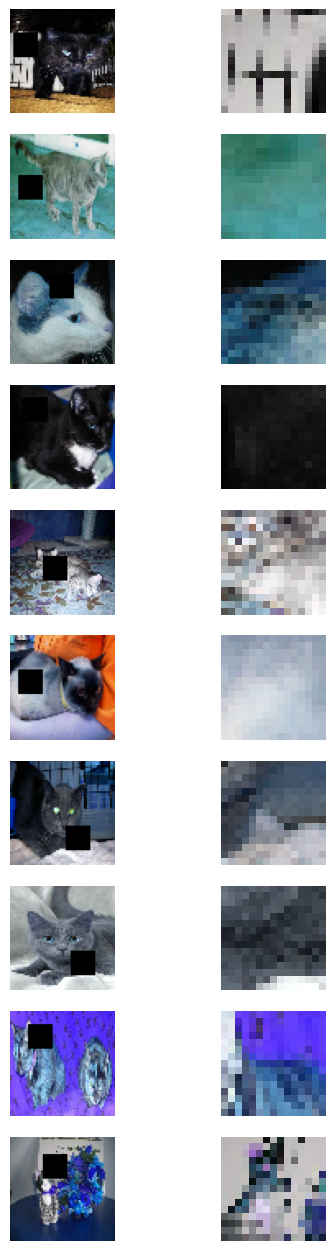

In [90]:
base = 3000
amount = 10
fig, axes = plt.subplots(amount, 2, figsize=(5, 16))
for i in range(base,base + amount):
    axes[i - base][0].imshow(train_df['image_x'].iloc[i][:,:,:3])
    axes[i - base][0].axis('off')
    axes[i - base][1].imshow(train_df['image_y'].iloc[i][:,:,:3])
    axes[i - base][1].axis('off')
plt.show()

In [52]:
X_train = np.stack(train_df['image_x'].values)
y_train = np.stack(train_df['image_y'].values)
y_train = y_train.reshape(y_train.shape[0],box_size[0]*box_size[1]*3)

In [53]:
history = euclidean_model_1.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[lr_scheduler],
    validation_split=0.5
)



Epoch 1/5
712/712 [==============================] - 966s 1s/step - loss: 17791.6758 - mae: 114.9173 - val_loss: 17240.9395 - val_mae: 112.9236 - lr: 0.0010
Epoch 2/5
712/712 [==============================] - 977s 1s/step - loss: 17790.4707 - mae: 114.9123 - val_loss: 17239.9629 - val_mae: 112.9196 - lr: 0.0010
Epoch 3/5
712/712 [==============================] - 941s 1s/step - loss: 17789.9043 - mae: 114.9099 - val_loss: 17239.9629 - val_mae: 112.9196 - lr: 0.0010
Epoch 4/5
712/712 [==============================] - 962s 1s/step - loss: 17789.9082 - mae: 114.9100 - val_loss: 17239.9629 - val_mae: 112.9196 - lr: 0.0010
Epoch 5/5
712/712 [==============================] - 951s 1s/step - loss: 17789.9160 - mae: 114.9100 - val_loss: 17239.9629 - val_mae: 112.9196 - lr: 0.0010


In [54]:
import pickle

def save_history(history, path):
  with open(path, 'wb') as f:
    pickle.dump(history, f)

In [55]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CNN/trained-models"
HISTORY_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CNN/history"

In [57]:
euclidean_model_1.save(MODEL_PATH + "/euclidean_model_1.keras")
save_history(history.history, HISTORY_PATH + "/euclidean_model_64_history.pkl")

# Monitoring - History of loss function

In [58]:
def load_history(path):
  with open(path, "rb") as file:
    return pickle.load(file)

In [59]:
h1 = load_history(HISTORY_PATH + "/euclidean_model_64_history.pkl")

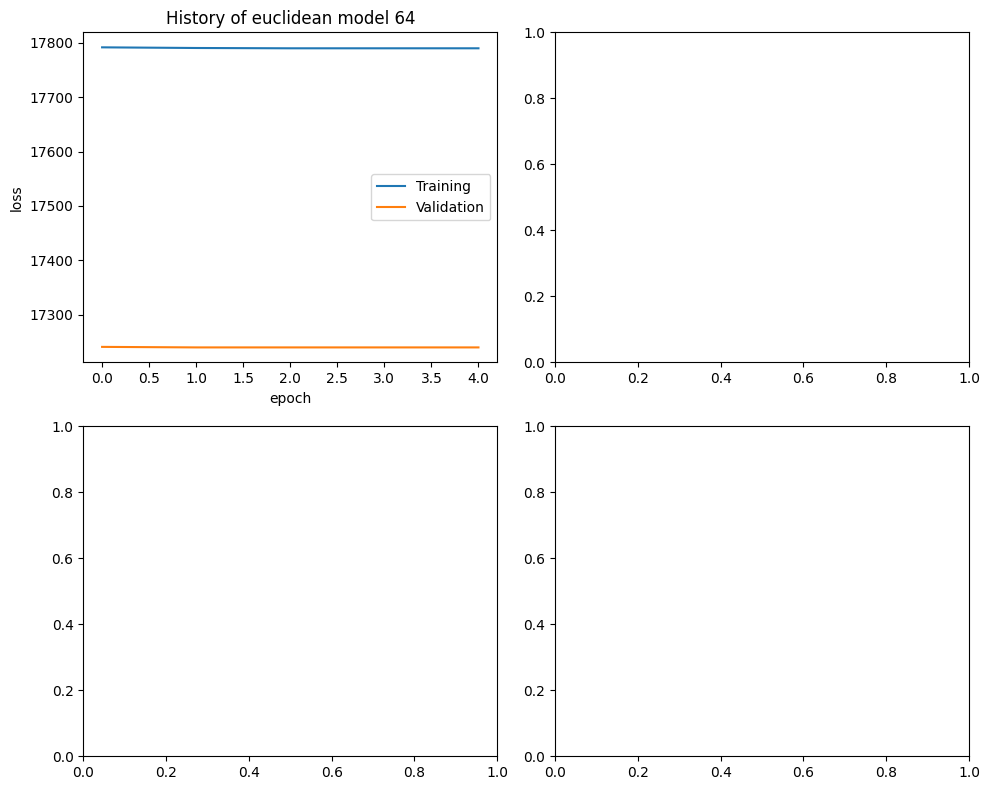

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(h1['loss'])
axes[0, 0].plot(h1['val_loss'])
axes[0, 0].set_title('History of euclidean model 64')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')
axes[0, 0].legend(['Training', 'Validation'])
plt.tight_layout()
plt.show()

# Predictions

In [61]:
from keras.models import load_model

euc1_model = load_model(MODEL_PATH + "/euclidean_model_1.keras")

In [62]:
def full_image(nb_img, center):
  modified_image = np.copy(nb_img)
  center_x = nb_img.shape[0] // 2
  center_y = nb_img.shape[1] // 2
  modified_image[center_x-5:center_x+5, center_y-5:center_y+5, :] = center

  return modified_image


def load_testing_dataset():
  TESTING_DATA_FOLDER = os.path.join('Dataset', 'Testing_Data')
  test_data = []

  csv_file = pd.read_csv(os.path.join(TESTING_DATA_FOLDER, 'masked_info.csv'))
  adjust_box_coordinate(csv_file)

  for filename in os.listdir(TESTING_DATA_FOLDER):
    if filename.endswith('.csv'):
            continue
    img = cv2.imread(os.path.join(TESTING_DATA_FOLDER, filename))
    img = cv2.resize(img, img_size)
    img_rgbm = draw_masks(img, csv_file[csv_file['filename'] == filename].iloc[0], box_size)
    test_data.append(img_rgbm)
  return test_data

In [63]:
x = X_train[0:5]

In [66]:
x = np.stack(x)

In [67]:
pred = euc1_model.predict(x)

1/1 [==============================] - 0s 261ms/step


In [ ]:
data[0].shape

(64, 64, 4)

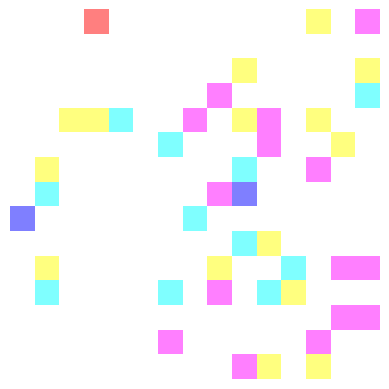

In [68]:
show_img(np.reshape(pred[4], (15, 15, 3)))

In [69]:
def full_image(x_rgbm_img, y_img):
  modified_image = np.copy(x_rgbm_img[:, :, :3])
  y_img_255 = y_img * 255
  mask = x_rgbm_img[:,:,3]

  coords = np.argwhere(mask == 1)

  x_min = np.min(coords[:, 0])
  y_min = np.min(coords[:, 1])

  modified_image[x_min:x_min+15, y_min:y_min+15, :] = y_img_255

  return modified_image

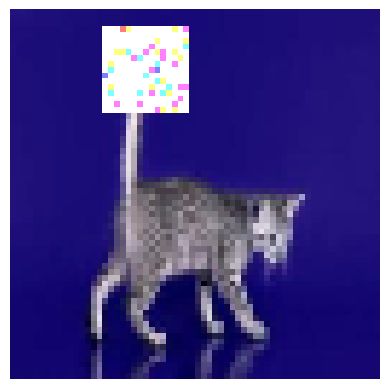

In [70]:
show_img(full_image(x[3],np.reshape(pred[3], (15, 15, 3))))